# GOES-19 IR channel subregion plot (using reprojected data)
This jupyter notebook shows how to make a sub-region plot of a **reprojected** IR channel of GOES-19.

Import the GOES package.

In [1]:
import GOES

Set path and name of file that will be read.

In [2]:
path = '/home/joao/Downloads/GOES-19/ABI/'
file = 'OR_ABI-L2-CMIPF-M6C13_G19_s20250782030193_e20250782039513_c20250782039584.nc'

Reads the file.

In [3]:
ds = GOES.open_dataset(path+file)

Prints the contents of the file.

In [4]:
print(ds)

<class 'GOES.processing.processing_data.open_dataset'>

attribute:
   naming_authority              : gov.nesdis.noaa
   Conventions                   : CF-1.7
   Metadata_Conventions          : Unidata Dataset Discovery v1.0
   standard_name_vocabulary      : CF Standard Name Table (v35, 20 July 2016)
   institution                   : DOC/NOAA/NESDIS > U.S. Department of Commerce, N...
   project                       : GOES
   production_site               : NSOF
   production_environment        : OE
   spatial_resolution            : 2km at nadir
   orbital_slot                  : GOES-Test
   platform_ID                   : G19
   instrument_type               : GOES-R Series Advanced Baseline Imager (ABI)
   scene_id                      : Full Disk
   instrument_ID                 : FM4
   dataset_name                  : OR_ABI-L2-CMIPF-M6C13_G19_s20250782030193_e20250...
   iso_series_metadata_id        : 8c9e8150-3692-11e3-aa6e-0800200c9a66
   title                         : A

Set the map domain.

In [5]:
domain = [-90.0,-30.0,-60.0,15.0]

Gets image with the coordinates of corners of their pixels.

In [6]:
CMI, LonCen, LatCen = ds.image('CMI', lonlat='center', domain=domain)

Gets information about data.

In [7]:
sat = ds.attribute('platform_ID')
band = ds.variable('band_id').data[0]
wl = ds.variable('band_wavelength').data[0]
standard_name = CMI.standard_name
units = CMI.units
time_bounds = CMI.time_bounds

Creates a grid map with cylindrical equidistant projection and 2 km of spatial resolution.

In [8]:
LonCenCyl, LatCenCyl = GOES.create_gridmap(domain, PixResol=2.0)

Calculates the coordinates of corners of pixels.

In [9]:
LonCorCyl, LatCorCyl = GOES.calculate_corners(LonCenCyl, LatCenCyl)

Calculates the parameters for reprojection. For this we need install the **pyproj** and **pyresample** packages. Try with ***pip install pyproj*** and ***pip install pyresample***.

In [10]:
import pyproj as pyproj
Prj = pyproj.Proj('+proj=eqc +lat_ts=0 +lat_0=0 +lon_0=0 +x_0=0 +y_0=0 +a=6378.137 +b=6378.137 +units=km')
AreaID = 'cyl'
AreaName = 'cyl'
ProjID = 'cyl'
Proj4Args = '+proj=eqc +lat_ts=0 +lat_0=0 +lon_0=0 +x_0=0 +y_0=0 +a=6378.137 +b=6378.137 +units=km'

ny, nx = LonCenCyl.data.shape
SW = Prj(LonCenCyl.data.min(), LatCenCyl.data.min())
NE = Prj(LonCenCyl.data.max(), LatCenCyl.data.max())
area_extent = [SW[0], SW[1], NE[0], NE[1]]

from pyresample import utils
AreaDef = utils.get_area_def(AreaID, AreaName, ProjID, Proj4Args, nx, ny, area_extent)

Reprojects image.

In [11]:
from pyresample.geometry import SwathDefinition
from pyresample.kd_tree import resample_nearest
import numpy as np

SwathDef = SwathDefinition(lons=LonCen.data, lats=LatCen.data)
CMICyl = resample_nearest(SwathDef, CMI.data, AreaDef, radius_of_influence=6000,
                          fill_value=np.nan, epsilon=3, reduce_data=True)

Deletes unnecessary data.

In [12]:
del CMI, LonCen, LatCen, SwathDef, LonCenCyl, LatCenCyl

Creates a custom color palette using the [custom_color_palette](https://github.com/joaohenry23/custom_color_palette) package.

In [13]:
# import packages
import custom_color_palette as ccp
import matplotlib.pyplot as plt

# set the colors of the custom palette
lower_colors = ['maroon','red','darkorange','#ffff00','forestgreen','cyan','royalblue',(148/255,0/255,211/255)]
lower_palette = [lower_colors, ccp.range(180.0,240.0,1.0)]

upper_colors = plt.cm.Greys
upper_palette = [upper_colors, ccp.range(240.0,330.0,1.0), [ccp.range(180.0,330.0,1.0),240.0,330.0]]

# pass parameters to the creates_palette module
cmap, cmticks, norm, bounds = ccp.creates_palette([lower_palette, upper_palette], extend='both')

# creating colorbar labels
ticks = ccp.range(180,330,10)

Creates plot.

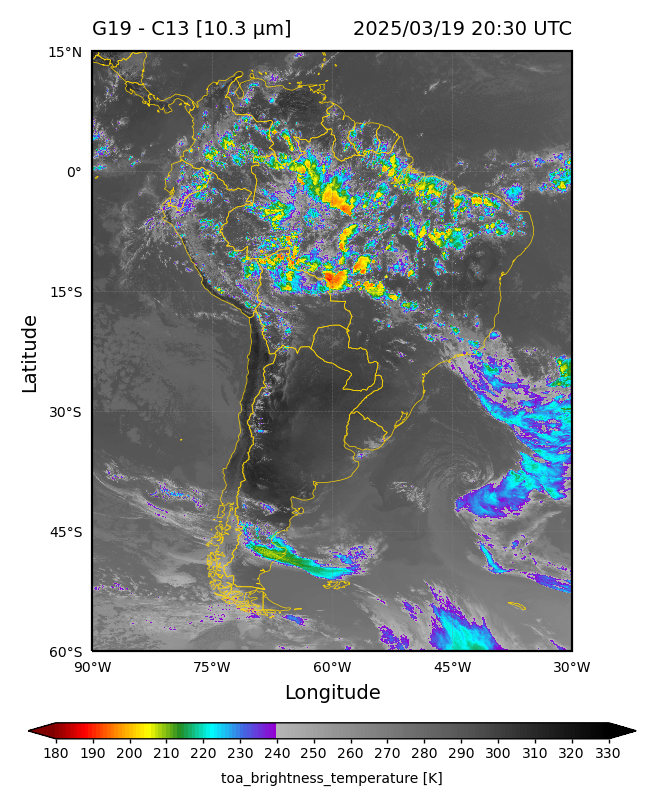

In [14]:
# import packages
import numpy as np
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter

# calculates the central longitude of the plot
lon_cen = 360.0+(domain[0]+domain[1])/2.0

# creates the figure
fig = plt.figure('map', figsize=(4,4), dpi=200)
ax = fig.add_axes([0.1, 0.16, 0.80, 0.75], projection=ccrs.PlateCarree(lon_cen))
#ax.outline_patch.set_linewidth(0.3)

# add the geographic boundaries
l = NaturalEarthFeature(category='cultural', name='admin_0_countries', scale='50m', facecolor='none')
ax.add_feature(l, edgecolor='gold', linewidth=0.25)

# plot the data
img = ax.pcolormesh(LonCorCyl.data, LatCorCyl.data, CMICyl.data, cmap=cmap, norm=norm,
                    transform=ccrs.PlateCarree())

# add the colorbar
cb = plt.colorbar(img, ticks=ticks, orientation='horizontal', extend='both',
                  cax=fig.add_axes([0.12, 0.05, 0.76, 0.02]))
cb.ax.tick_params(labelsize=5, labelcolor='black', width=0.5, length=1.5, direction='out', pad=1.0)
cb.set_label(label='{} [{}]'.format(standard_name, units), size=5, color='black', weight='normal')
cb.outline.set_linewidth(0.5)

# set the title
ax.set_title('{} - C{:02d} [{:.1f} μm]'.format(sat,band, wl), fontsize=7, loc='left')
ax.set_title(time_bounds.data[0].strftime('%Y/%m/%d %H:%M UTC'), fontsize=7, loc='right')

# Sets X axis characteristics
dx = 15
xticks = np.arange(domain[0], domain[1]+dx, dx)
ax.set_xticks(xticks, crs=ccrs.PlateCarree())
ax.xaxis.set_major_formatter(LongitudeFormatter(dateline_direction_label=True))
ax.set_xlabel('Longitude', color='black', fontsize=7, labelpad=3.0)

# Sets Y axis characteristics
dy = 15
yticks = np.arange(domain[2], domain[3]+dy, dy)
ax.set_yticks(yticks, crs=ccrs.PlateCarree())
ax.yaxis.set_major_formatter(LatitudeFormatter())
ax.set_ylabel('Latitude', color='black', fontsize=7, labelpad=3.0)

# Sets tick characteristics
ax.tick_params(left=True, right=True, bottom=True, top=True,
               labelleft=True, labelright=False, labelbottom=True, labeltop=False,
               length=0.0, width=0.05, labelsize=5.0, labelcolor='black')

# Sets grid characteristics
ax.gridlines(xlocs=xticks, ylocs=yticks, alpha=0.6, color='gray',
             draw_labels=False, linewidth=0.25, linestyle='--')

# set the map limits
ax.set_extent([domain[0]+360.0, domain[1]+360.0, domain[2], domain[3]], crs=ccrs.PlateCarree())

plt.show()